**数据集：**
- Day 1-10: Train
- Day 11-13: Validation
- Day 22-23: Test

**预测目标：**
超短期预测（4h/15min）的风功率

**可调的参数：**
- 使用前多久的数据进行预测:400
- 数据集的特征: speed power
- LSTM units 数目:
- batch size: 32
- epoch: 100

In [1]:
u = 75

n_back = 400
n_out = 16
n_pre = n_out*15*2
n_feature = 2

train_len = 10

# Preperation

In [2]:
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2023-01-12 14:42:45.960594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 14:42:46.447447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 14:42:46.447501: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 14:42:48.523115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [8]:
dataset = pd.read_csv('../wind_preprocessed.csv', header=0, index_col=0).query('day==22|day==23')

In [9]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-22 00:00:00  0.25314  0.08897
2015-10-22 00:00:30  0.25481  0.09182
2015-10-22 00:01:00  0.25584  0.09219
2015-10-22 00:01:30  0.25705  0.09681
2015-10-22 00:02:00  0.25777  0.09550


In [10]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [11]:
values = reframed.values
# 分为输入输出
n_obs = n_back * n_feature
test_X, test_y = values[:, :n_obs], values[:, -n_out:]
print(test_X.shape, test_y.shape)
# 重塑成3D格式 [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
print(test_X.shape, test_y.shape)

(4910, 800) (4910, 16)
(4910, 400, 2) (4910, 16)


# Testing

In [1]:
import pickle
with open('lstm_unit75_hist.pickle', 'rb') as f:
    history = pickle.load(f)

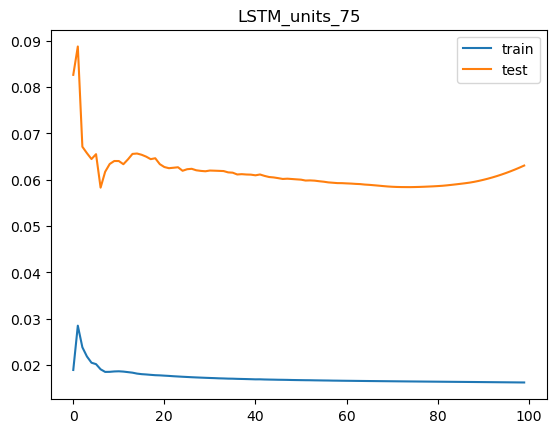

In [4]:
# 画图
fig,ax = plt.subplots()
ax.plot(history['loss'], label='train')
ax.plot(history['val_loss'], label='test')
plt.title(f'LSTM_units_{u}')
plt.legend()
plt.savefig(f'LSTM_units_{u}.png')

In [63]:
model = Sequential()
model.add(LSTM(u, input_shape=(test_X.shape[1], test_X.shape[2])))
model.add(Dense(n_out))
model.load_weights("75.h5")

In [40]:
yreal = model.predict(test_X)

154/154 [==============================] - 18s 115ms/step


In [50]:
rmse = np.std(yreal - test_y, axis = 0)
acc = (np.ones_like(rmse) - rmse)*100
print('RMSE:', np.mean(rmse))
print('Accuracy', np.mean(acc))
print(len(rmse))

RMSE: 0.16464844
Accuracy 83.53516
16


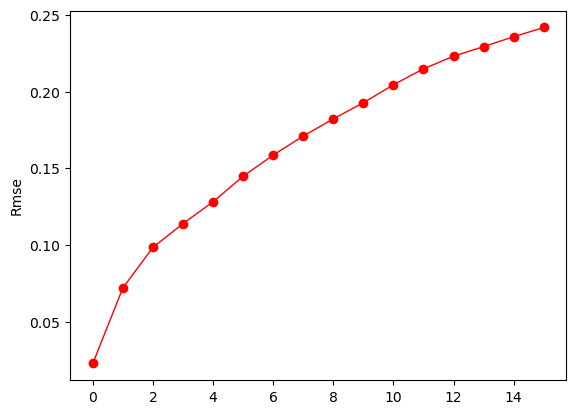

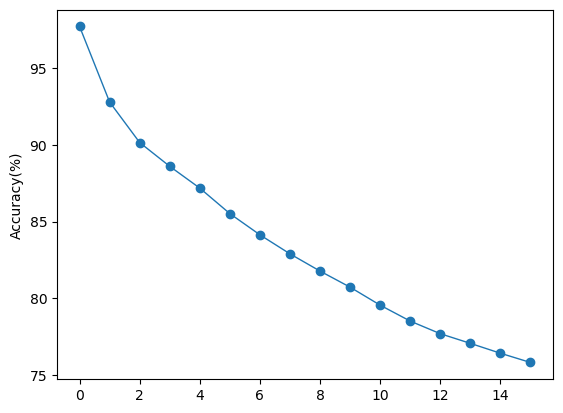

In [42]:
t = np.arange(0, 16, 1)
plt.scatter(t,rmse,color = 'r')
plt.plot(t, rmse,"-",color='r', linewidth=1)
plt.ylabel('Rmse')
plt.show()
plt.scatter(t,acc)
plt.plot(t, acc,"-", linewidth=1)
plt.ylabel('Accuracy(%)')
plt.show()

In [53]:
rmse_i = np.std(yreal - test_y, axis = 1)
acc_i = (np.ones_like(rmse_i) - rmse_i)*100
print('RMSE:', np.mean(rmse_i))
print('Accuracy', np.mean(acc_i))
print(len(rmse_i))

RMSE: 0.09147974
Accuracy 90.85202
4910


In [44]:
print(np.where(rmse==min(rmse)))

(array([3266]),)


1/1 [==============================] - 0s 155ms/step


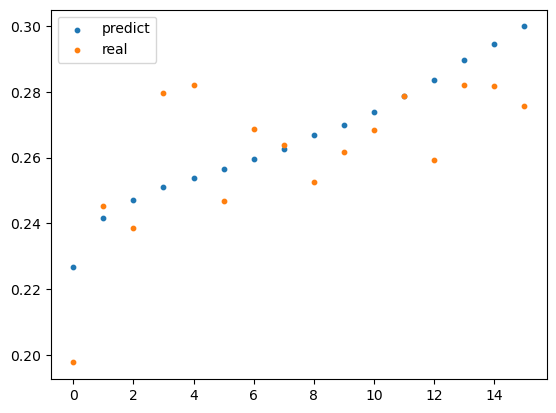

In [45]:
# 随机指定test_X中的一个sample看预测效果
i = 3266
# 做出预测
yhat_i = model.predict(test_X[i][:][:].reshape(1, n_back, 2))[0]
yreal_i = test_y.reshape((len(test_y), n_out))[i]
# 计算RMSE
rmse = sqrt(mean_squared_error(yreal_i, yhat_i))
# 计算平均相对误差
sigma = np.mean((yhat_i - yreal_i) / yreal_i * 100)

t = np.arange(0, len(yhat_i), 1)
plt.scatter(t, yhat_i, label='predict', s=10)
plt.scatter(t, yreal_i, label='real', s=10)
plt.legend()
plt.show()

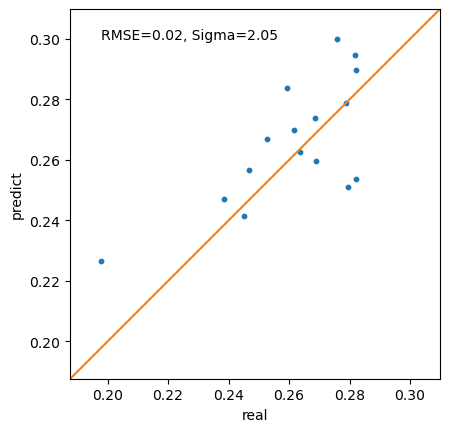

In [46]:
x = np.arange(0, 1, 0.1)
plt.plot(x, x, color='C1')
plt.scatter(yreal_i, yhat_i, s=10)
# plt.plot(yreal, yreal, color='C1')
plt.xlabel('real')
plt.ylabel('predict')
plt.gca().set_aspect(1)
plt.xlim(min(min(yreal_i), min(yhat_i))-0.01, max(max(yreal_i), max(yhat_i))+0.01)
plt.ylim(min(min(yreal_i), min(yhat_i))-0.01, max(max(yreal_i), max(yhat_i))+0.01)
plt.text(min(min(yreal_i), min(yhat_i)), max(max(yreal_i), max(yhat_i)), 'RMSE={:.2f}, Sigma={:.2f}'.format(rmse, sigma))
plt.show()

In [17]:
# # 预测test_X中所有sample
# from tqdm import trange
# sigmas = []
# rmses = []
# for i in trange(test_X.shape[0]):
#     yhat = model.predict(test_X[i][:][:].reshape(1, n_back, 2), verbose=0)[0]
#     yreal = test_y.reshape((len(test_y), n_out))[i]
#     rmse = sqrt(mean_squared_error(yreal, yhat))
#     sigma = np.mean((yhat - yreal) / yreal * 100)
#     rmses.append(rmse)
#     sigmas.append(sigma)

 39%|███▉      | 1933/4910 [04:25<06:49,  7.28it/s]


KeyboardInterrupt: 

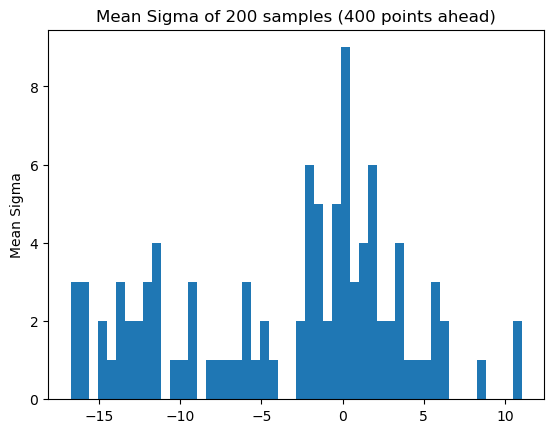

In [15]:
# plt.hist(sigmas, bins=50)
# plt.ylabel('Mean Sigma')
# plt.title('Mean Sigma of 200 samples (400 points ahead)')
# # plt.xlim(0, 100)
# plt.show()

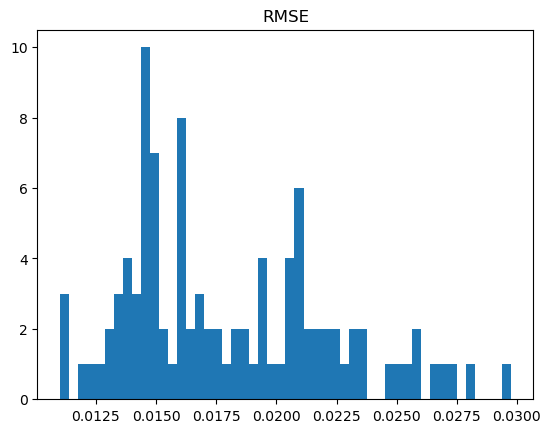

In [16]:
# plt.hist(rmses, bins=50)
# plt.title('RMSE')
# plt.show()